# Analyse de Stratégie de Trading avec Backtesting

Dans le domaine dynamique des marchés financiers, tester de manière efficace et sûre les stratégies de trading avant de les déployer peut significativement augmenter les chances de succès et minimiser les risques potentiels associés aux fluctuations imprévisibles du marché. Ce notebook présente un cadre exhaustif pour le backtesting de la  stratégie de trading RSI. 

## Importation des librairies: 

In [24]:
import numpy as np
import pandas as pd
import yfinance as yf
from tqdm import tqdm
from scipy.stats import linregress
from sklearn.base import BaseEstimator
from typing import Optional, List
import matplotlib.pyplot as plt
from datetime import time, datetime



## classe 'stratetgy' : 

Cette classe implémente une stratégie de trading utilisant l'indice de force relative (RSI), un indicateur clé pour évaluer la dynamique des prix sur les marchés financiers. Le RSI aide à identifier les moments où un actif est potentiellement suracheté ou survendu, suggérant des points d'entrée ou de sortie pour les transactions.

Fonctionnalités:
* **Initialisation** : Prépare les paramètres initiaux de la stratégie, incluant la fenêtre de calcul du RSI fixée à 14 périodes, typique pour cet indicateur.
* **Calcul du RSI** : Détermine le niveau de RSI à partir des variations de prix, calculant les moyennes de gains et de pertes sur la période définie.
* **Gestion des Signaux de Trading** : Utilise le RSI pour décider quand entrer ou sortir des positions:
* **Entrée en Position Longue** : Engage une position d'achat si le RSI descend en dessous de 30.
* **Sortie de Position Longue** : Liquide une position d'achat si le RSI monte au-dessus de 70.
* **Entrée en Position Courte** : Initie une position de vente à découvert si le RSI excède 70.
* **Sortie de Position Courte** : Clôt une position de vente à découvert si le RSI chute en dessous de 30.

Cette approche basique mais efficace permet d'exploiter les retournements de tendance présumés basés sur le RSI, offrant un cadre structuré pour les décisions de trading selon les variations du marché.

In [25]:
class Strategy:
    def __init__(self):
        self.rsi_window = 14  # Fenêtre RSI
        self.in_position = False
        self.position_type = None  # 'long' ou 'short'

    def init(self):
        self.in_position = False
        self.position_type = None

    def calculate_rsi(self, prices):
        deltas = np.diff(prices)
        gain = np.where(deltas > 0, deltas, 0).sum()
        loss = np.where(deltas < 0, -deltas, 0).sum()
        average_gain = gain / self.rsi_window
        average_loss = loss / self.rsi_window
        rs = average_gain / average_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def on_data(self, index, lows, highs, closes, opens, dates, backtest_instance):
        if index < self.rsi_window:
            return  # Pas assez de données pour calculer le RSI

        rsi = self.calculate_rsi(closes[index-self.rsi_window:index+1])

        if not self.in_position and rsi < 30:
            # Condition pour entrer une position longue
            entry_price = closes[index]
            position_size = backtest_instance.allocate_position_size(entry_price)
            backtest_instance.enter_position('long', entry_price, position_size, dates[index])
            self.in_position = True
            self.position_type = 'long'
        elif self.in_position and self.position_type == 'long' and rsi > 70:
            # Condition pour sortir d'une position longue
            current_price = closes[index]
            backtest_instance.close_position(self.positions[-1], current_price, dates[index])
            self.in_position = False
        elif not self.in_position and rsi > 70:
            # Condition pour entrer une position courte
            entry_price = closes[index]
            position_size = backtest_instance.allocate_position_size(entry_price)
            backtest_instance.enter_position('short', entry_price, position_size, dates[index])
            self.in_position = True
            self.position_type = 'short'
        elif self.in_position and self.position_type == 'short' and rsi < 30:
            # Condition pour sortir d'une position courte
            current_price = closes[index]
            backtest_instance.close_position(self.positions[-1], current_price, dates[index])
            self.in_position = False


## classe 'Backtest': 

La classe **Backtest** est conçue pour exécuter des simulations de stratégies de trading sur des données historiques, permettant aux utilisateurs de tester l'efficacité de leurs stratégies avant de les mettre en œuvre sur des marchés réels.

**Caractéristiques Principales**:

**Initialisation** :

- Prépare l'environnement de backtesting avec les données de marché nécessaires, la stratégie de trading à tester, et initialise le capital initial.
- Simulation : Exécute la stratégie sur l'ensemble des données, enregistrant les positions ouvertes et fermées ainsi que les résultats financiers correspondants.
- Gestion des Positions : Suit activement chaque position ouverte pour déterminer si les conditions de sortie (prise de profit ou arrêt des pertes) sont remplies.

**Fonctionnalités Détaillées**:

- Construction de l'Objet : Initialise le cadre avec les données historiques formatées et les paramètres de la stratégie.
- Exécution : Parcourt chronologiquement les données de marché et applique la stratégie de trading à chaque intervalle de temps, ajustant le portefeuille en fonction des signaux de trading générés.
- Surveillance des Positions : Vérifie régulièrement chaque position pour les clôtures basées sur les critères prédéfinis de stop-loss et take-profit.
- Analyse des Résultats : Après avoir complété la simulation, compile les résultats et les statistiques de performance, tels que le taux de gain, le profit net, et d'autres indicateurs financiers clés.

In [26]:
class Backtest:
    def __init__(self, data: pd.DataFrame, strategy, initial_cash=100000,
                 model: Optional = None, columns: Optional[List[str]] = None,
                 rows: Optional[int] = None, cs_pattern: bool = False):
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Les données doivent être un DataFrame de pandas.")
        if 'date' not in data.columns:
            raise ValueError("Les données doivent contenir une colonne 'date'.")

        data['date'] = pd.to_datetime(data['date'])
        data.set_index('date', inplace=True)

        self.data = data
        self.strategy = strategy
        self.initial_cash = initial_cash
        self.cash = initial_cash
        self.equity_peak = initial_cash
        self.max_drawdown = 0
        self.positions = []
        self.completed_trades = []
        self.trade_counter = 0
        self.long_wins = 0
        self.short_wins = 0
        self.long_loses = 0
        self.short_loses = 0
        self.long_evens = 0
        self.short_evens = 0
        self.gross_profit = 0
        self.gross_loss = 0
        self.start_time = None
        self.end_time = None
        self.model = model
        self.columns = columns
        self.rows = rows
        self.cs_pattern = cs_pattern

        self.market_data = yf.download('^GSPC', start=self.data.index.min(), end=self.data.index.max())
        self.market_data['Adj Close'] = self.market_data['Adj Close'].pct_change().dropna()
        self.market_data.set_index(pd.to_datetime(self.market_data.index), inplace=True)

        self.run()
        self.results()

    def run(self):
        
        dates = self.data.index
        lows = self.data['low'].values
        highs = self.data['high'].values
        closes = self.data['close'].values
        opens = self.data['open'].values

        self.start_time = dates[0]
        self.end_time = dates[-1]

        self.strategy.init()

        for index in tqdm(range(len(dates)), total=len(dates), desc="Exécution du backtest"):
            self.strategy.on_data(index, lows[:index + 1], highs[:index + 1], closes[:index + 1], opens[:index + 1], dates[:index + 1], self)
            self.check_positions(index, dates[index], lows[index], highs[index])
            
    def calculate_beta(self):
        asset_returns = self.data['close'].pct_change().dropna()
        market_returns = self.market_data['Adj Close'].dropna()

        if asset_returns.empty or market_returns.empty:
            return np.nan

        # Alignement des indices
        market_returns = market_returns.reindex(asset_returns.index).fillna(method='pad')

        # Covariance and variance
        covariance = np.cov(asset_returns, market_returns)[0, 1]
        variance = np.var(market_returns)

        if variance == 0:
            return np.nan

        return covariance / variance


    def check_positions(self, index, date, low, high):
        for position in list(self.positions):
            if position['type'] == 'long' and (low <= position['stop loss'] or high >= position['take profit']):
                self.close_position(position, high if high >= position['take profit'] else low, date)
            elif position['type'] == 'short' and (high >= position['stop loss'] or low <= position['take profit']):
                self.close_position(position, low if low <= position['take profit'] else high, date)

    def close_position(self, position, exit_price, exit_time):
        profit_loss = (exit_price - position['entry price']) * position['position size'] if position['type'] == 'long' else (position['entry price'] - exit_price) * position['position size']
        
        self.cash += profit_loss
        self.update_metrics(profit_loss, position['type'])
        
        position.update({
            'exit price': exit_price,
            'exit time': exit_time,
            'pnl': profit_loss
        })
        self.completed_trades.append(position)
        self.positions.remove(position)
        self.strategy.in_position = False
        
    def enter_position(self, position_type, entry_price, position_size, entry_time):
        position = {
            'type': position_type,
            'entry price': entry_price,
            'position size': position_size,
            'entry time': entry_time,
            'stop loss': entry_price * 0.95 if position_type == 'long' else entry_price * 1.05,  # hyp 5% stop loss rule
            'take profit': entry_price * 1.05 if position_type == 'long' else entry_price * 0.95  # hyp 5% take profit rule
        }
        self.positions.append(position)

    def update_metrics(self, profit_loss, position_type):
        if profit_loss > 0:
            if position_type == 'long':
                self.long_wins += 1
            else:
                self.short_wins += 1
            self.gross_profit += profit_loss
        else:
            if position_type == 'long':
                self.long_loses += 1
            else:
                self.short_loses += 1
            self.gross_loss += profit_loss

        if self.cash > self.equity_peak:
            self.equity_peak = self.cash
        else:
            drawdown = self.equity_peak - self.cash
            self.max_drawdown = max(self.max_drawdown, drawdown)

    def results(self):
        wins = self.short_wins + self.long_wins
        loses = self.short_loses + self.long_loses
        win_rate = np.around((wins / (wins + loses)) * 100, decimals=2) if wins + loses > 0 else 0
        net_profit = np.around(self.gross_profit + self.gross_loss, decimals=2)
        profit_factor = np.around(self.gross_profit / abs(self.gross_loss), decimals=2) if self.gross_loss != 0 else float('inf')
        beta = self.calculate_beta()
        daily_returns = self.data['close'].pct_change().dropna()
        self.mean_return = np.mean(daily_returns)
        self.variance = np.var(daily_returns)

        self.backtest_result = [{
            'Heure de début': self.start_time,
            'Heure de fin': self.end_time,
            'Nombre de trades': self.trade_counter,
            'Nombre de victoires': wins,
            'Nombre de défaites': loses,
            'Taux de victoire': f'{win_rate}%',
            'Bénéfice net': net_profit,
            'Drawdown maximal': f'-{np.around(self.max_drawdown, decimals=2)}',
            'Bénéfice brut': np.around(self.gross_profit, decimals=2),
            'Perte brute': np.around(self.gross_loss, decimals=2),
            'Facteur de profit': profit_factor,
            'Beta': beta,
            'mean return': f'{self.mean_return:.2%}',
            'variance': f'{self.variance:.2%}'
        }]
        self.backtest_df = pd.DataFrame(self.backtest_result).T


    def calculate_additional_stats(self):
        daily_returns = self.data['close'].pct_change().dropna()
        self.mean_return = np.mean(daily_returns)
        self.variance = np.var(daily_returns)

        # Rajout des nouvelles stats au dictionnarire: 
        self.backtest_result[0].update({
            'mean return': f'{self.mean_return:.2%}',
            'variance': f'{self.variance:.2%}'
        })

    def allocate_position_size(self, entry_price):
        max_risk_per_trade = self.cash * 0.01  # Risque 1% du cash actuel par trade
        risk_per_unit = entry_price * 0.05  # Stop loss estimé à 5% sous le prix d'entrée
        position_size = max_risk_per_trade / risk_per_unit
        return position_size

    def get_trades(self):
        return pd.DataFrame(self.completed_trades)

    def get_results(self):
        return self.backtest_df

    def plot_results(self):
        plt.figure(figsize=(10, 5))
        # Use the index directly since 'date' is set as the DataFrame index
        plt.plot(self.data.index, self.data['close'], label='Prix de Clôture')
        plt.title('Performance de la Stratégie')
        plt.xlabel('Date')
        plt.ylabel('Prix')
        plt.legend()
        plt.show()



## Output :

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Exécution du backtest: 100%|██████████| 61/61 [00:00<00:00, 4374.59it/s]


Backtest Results Summary:
                                       0
Heure de début       2024-01-02 00:00:00
Heure de fin         2024-03-28 00:00:00
Nombre de trades                       0
Nombre de victoires                    2
Nombre de défaites                     1
Taux de victoire                  66.67%
Bénéfice net                      786.23
Drawdown maximal                -1228.25
Bénéfice brut                    2014.48
Perte brute                     -1228.25
Facteur de profit                   1.64
Beta                            0.892351
mean return                       -0.12%
variance                           0.02%

Trade Details:
    type  entry price  position size entry time   stop loss  take profit  \
0  short   194.169998     103.002525 2024-01-25  203.878498   184.461498   
1   long   185.039993     109.178002 2024-02-13  175.787994   194.291993   
2   long   170.119995     117.309234 2024-03-05  161.613995   178.625995   

   exit price  exit time          pnl 

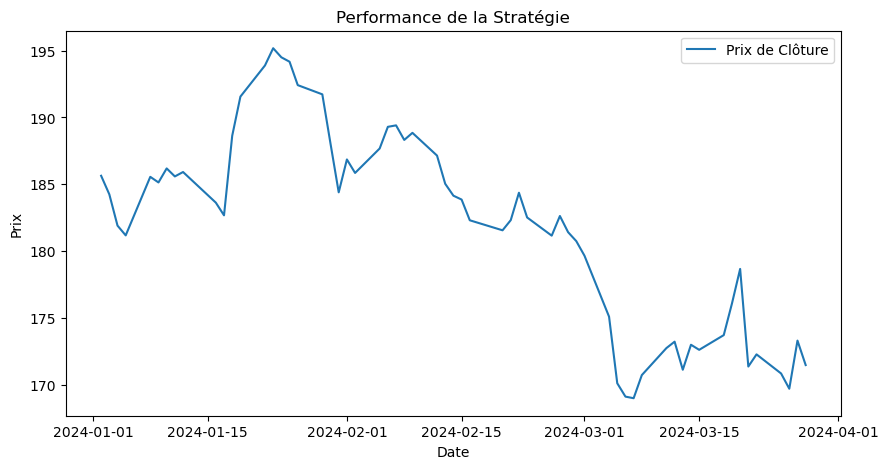

In [27]:
import yfinance as yf

# Load and prepare data
data = yf.download('AAPL', start='2024-01-01', end='2024-03-31')
data.reset_index(inplace=True)
data.columns = ['date', 'open', 'high', 'low', 'close', 'adj close', 'volume']
data.drop(['adj close'], axis=1, inplace=True)

# Initialize and run backtest
strategy = Strategy()
backtest = Backtest(data, strategy)



# Display summarized results and plots
results_df = backtest.get_results()
trades_df = backtest.get_trades()

print("Backtest Results Summary:")
print(results_df)

print("\nTrade Details:")
print(trades_df)

backtest.plot_results()



# Bonus : 

In [28]:
class MorningStarDoji(Strategy):
    def __init__(self):
        super().__init__()
        # Définir les heures d'ouverture et de fermeture du marché
        self.market_open_time = time(9, 30)
        self.market_close_time = time(16, 10)

    def trading_hours(self, current_date):
        # Vérifie si l'heure actuelle est dans les heures de trading
        return self.market_open_time <= current_date.time() <= self.market_close_time

    def on_data(self, index, lows, highs, closes, opens, dates, backtest_instance):
        # Vérifie si on a assez de données pour analyser
        if index > 1:
            # Collecter les données des trois derniers jours
            prev_open = opens[index - 1]
            prev_close = closes[index - 1]
            prev_high = highs[index - 1]
            prev_low = lows[index - 1]

            b_prev_open = opens[index - 2]
            b_prev_close = closes[index - 2]
            b_prev_high = highs[index - 2]
            b_prev_low = lows[index - 2]

            current_open = opens[index]
            current_close = closes[index]
            current_high = highs[index]
            current_low = lows[index]
            current_date = dates[index]

            # Appel à la méthode de détection de motif
            if self.is_morning_star_doji(b_prev_open, b_prev_close, b_prev_high, b_prev_low,
                                         prev_open, prev_close, prev_high, prev_low,
                                         current_open, current_close, current_high, current_low) \
               and not self.in_position and self.trading_hours(current_date):
                # Définir les paramètres de l'entrée en position
                entry_price = current_close
                take_profit = entry_price + 50  # Objectif de profit arbitraire
                stop_loss = entry_price - 37   # Perte d'arrêt arbitraire
                entry_time = current_date

                # Entrer une position
                backtest_instance.enter_position('long', entry_price, take_profit, stop_loss, entry_time)

    def is_morning_star_doji(self, b_prev_open, b_prev_close, b_prev_high, b_prev_low,
                             prev_open, prev_close, prev_high, prev_low,
                             current_open, current_close, current_high, current_low):
        # Détection de la configuration "Morning Star Doji"
        # C'est une logique simplifiée et doit être adaptée à vos critères spécifiques
        return (prev_close < prev_open) and (b_prev_close < b_prev_open) \
               and (current_close > current_open) and (current_close > b_prev_close) \
               and (current_open > prev_close)
